In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Weekly Data

### Step 1
First, I just bring in the data from SPY and VIX. The data is from Feb 11 2007 to Feb 11 2022. It is weekly data that I pulled from Yahoo Finance. I remove the Open, High, Low, Close, and Volume columns, as our strtagey is working with Adj Close data.

In [2]:
dfspy = pd.read_csv('SPY.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfspy = dfspy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfspy = dfspy.rename(columns = {'Adj Close' : 'SPY Adj Close'})
dfspy.head()

,SPY Adj Close
Date,
2007-02-12,108.318275
2007-02-19,107.998672
2007-02-26,103.070694
2007-03-05,104.639046
2007-03-12,102.966667


In [3]:
dfvix = pd.read_csv('^VIX.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfvix = dfvix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfvix = dfvix.rename(columns = {'Adj Close' : 'VIX Adj Close'})
dfvix

,VIX Adj Close
Date,
2007-02-12,10.020000
2007-02-19,10.580000
2007-02-26,18.610001
2007-03-05,14.090000
2007-03-12,16.790001
...,...
2022-01-10,19.190001
2022-01-17,28.850000
2022-01-24,27.660000


### Step 2
I merge the dataframes of SPY and VIX data. I then split the data into a 70-30 split. 

In [4]:
df = dfspy.join(dfvix, on='Date')
dftrain = df[:(int(0.7*len(df)))]
dftest = df[(int(0.7*len(df))):]
dftrain.head()

,SPY Adj Close,VIX Adj Close
Date,,
2007-02-12,108.318275,10.020000
2007-02-19,107.998672,10.580000
2007-02-26,103.070694,18.610001
2007-03-05,104.639046,14.090000
2007-03-12,102.966667,16.790001


### Step 3
The code for the strategy function

In [5]:
def strategy(df_og, ema_span=(12,26), sig_span=9, quant1=0.25, quant2=0.75, vix_span=100):
    df = df_og.copy()
    df['12EMA'] = df['SPY Adj Close'].ewm(span = ema_span[0], adjust = False).mean()
    df['26EMA'] = df['SPY Adj Close'].ewm(span = ema_span[1], adjust = False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal'] = df['MACD'].ewm(span = sig_span, adjust = False).mean()
    df['Long'] = np.where(((df['MACD'] > df['Signal']) &
                               ((df['MACD'] < 0) |
                                df['VIX Adj Close'] < df['VIX Adj Close'].rolling(vix_span).quantile(quant1))),1,0)
    df['Short'] = np.where(((df['MACD'] < df['Signal']) &
                               (df['VIX Adj Close'] > df['VIX Adj Close'].rolling(vix_span).quantile(quant2))), -1, 0)
    df['SPY returns'] = df['SPY Adj Close'].pct_change()
    df['Position'] = df['Long'] + df['Short']
    df['P&L Long'] = df['Long']*df['SPY returns']
    df['P&L Short'] = df['Short']*df['SPY returns']
    df['P&L'] = df['Position']*df['SPY returns']
    return df

In [6]:
train = strategy(dftrain)
train.head()

,SPY Adj Close,VIX Adj Close,12EMA,26EMA,MACD,Signal,Long,Short,SPY returns,Position,P&L Long,P&L Short,P&L
Date,,,,,,,,,,,,,
2007-02-12,108.318275,10.020000,108.318275,108.318275,0.000000,0.000000,0,0,NaN,0,NaN,NaN,NaN
2007-02-19,107.998672,10.580000,108.269105,108.294601,-0.025495,-0.005099,0,0,-0.002951,0,-0.0,-0.0,-0.0
2007-02-26,103.070694,18.610001,107.469350,107.907645,-0.438295,-0.091738,0,0,-0.045630,0,-0.0,-0.0,-0.0
2007-03-05,104.639046,14.090000,107.033918,107.665526,-0.631608,-0.199712,0,0,0.015216,0,0.0,0.0,0.0
2007-03-12,102.966667,16.790001,106.408187,107.317463,-0.909275,-0.341625,0,0,-0.015982,0,-0.0,-0.0,-0.0


In [7]:
def results(df, per_year=52):
    train = df.copy()
    i = 0
    for index, row in df.iterrows():
        if (row['Position'] == 0):
            i = i + 1
        else:
            break
    train = train[i:]
    print("The median of rolling mean of SPY returns was", train['SPY returns'].rolling(26).mean().median())
    print("The median of rolling mean of our strategy P&L was", train['P&L'].rolling(26).mean().median())
    print("The median of rolling volatilty of SPY returns was", train['SPY returns'].rolling(26).std().median())
    print("The median of rolling volatilty of our strategy was", train['P&L'].rolling(26).std().median())
    print("")
    print("The mean of rolling mean of SPY returns was", train['SPY returns'].rolling(26).mean().mean())
    print("The mean of rolling mean of our strategy P&L was", train['P&L'].rolling(26).mean().mean())
    print("The mean of rolling volatilty of SPY returns was", train['SPY returns'].rolling(26).std().mean())
    print("The mean of rolling volatilty of our strategy was", train['P&L'].rolling(26).std().mean())
    print("")
    print("dataset Strategy sharpe ratio (annualized):", train['P&L'].mean()*np.sqrt(per_year)/train['P&L'].std())
    print("datatset SPY sharpe ratio (annualized):", train['SPY returns'].mean()*np.sqrt(per_year)/train['SPY returns'].std())
    print("")
    print("Our positions' frequency are as follows: ")
    tp = pd.DataFrame(train['Position'].value_counts())
    print(tp)
    fig, ax = plt.subplots()
    train['Position'].value_counts().plot(ax=ax, kind='bar')
    print("")
    print("Mean returns of the long position (when it trades) are: ", (train['P&L Long'].sum()/tp['Position'][1]))
    print("Mean returns of the short position (when it trades) are: ", (train['P&L Short'].sum()/tp['Position'][-1]))
    print("Mean returns of SPY everyday is: ", train['SPY returns'].mean())
    print("")
    print("Cumulative sum of S&P500 returns", train['SPY returns'].cumsum())
    pnl = pd.DataFrame({'SPY':train['SPY returns'],
                   'Strategy':train['P&L']})
    pnl.cumsum().plot()
    pnl.plot()
    print("")
    position = pd.DataFrame({'Position': train['Position']})
    position.plot()
    

The median of rolling mean of SPY returns was 0.003007451331370598
The median of rolling mean of our strategy P&L was 0.0032650547003716564
The median of rolling volatilty of SPY returns was 0.01720708584449957
The median of rolling volatilty of our strategy was 0.01246047767433784

The mean of rolling mean of SPY returns was 0.003049033297508461
The mean of rolling mean of our strategy P&L was 0.003514374590238508
The mean of rolling volatilty of SPY returns was 0.01943030270895759
The mean of rolling volatilty of our strategy was 0.015350664359136014

dataset Strategy sharpe ratio (annualized): 1.2030043742653964
datatset SPY sharpe ratio (annualized): 0.9266502873549219

Our positions' frequency are as follows: 
    Position
 1       255
 0       145
-1        49

Mean returns of the long position (when it trades) are:  0.004233447648072244
Mean returns of the short position (when it trades) are:  0.006397938818998797
Mean returns of SPY everyday is:  0.0027764883652499363

Cumulati

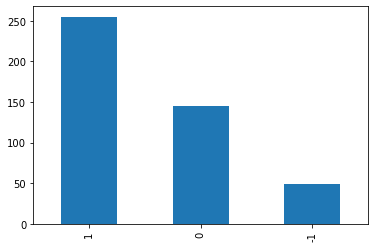

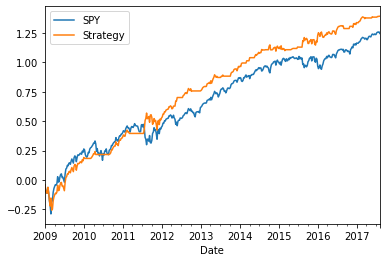

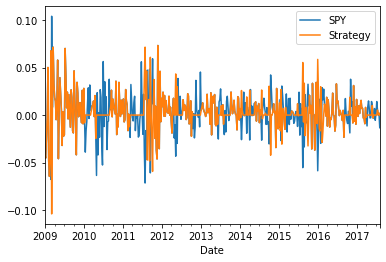

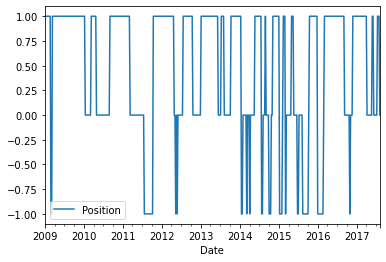

In [8]:
train = strategy(dftrain)
results(train, 52)

The median of rolling mean of SPY returns was 0.005063564747664438
The median of rolling mean of our strategy P&L was 0.006177693342170725
The median of rolling volatilty of SPY returns was 0.024283702047572193
The median of rolling volatilty of our strategy was 0.019597723377969067

The mean of rolling mean of SPY returns was 0.004528965665058466
The mean of rolling mean of our strategy P&L was 0.005874765901367719
The mean of rolling volatilty of SPY returns was 0.028485269324625147
The mean of rolling volatilty of our strategy was 0.0250457431937465

dataset Strategy sharpe ratio (annualized): 1.3235306914687657
datatset SPY sharpe ratio (annualized): 0.8980636875762584

Our positions' frequency are as follows: 
    Position
 1        77
 0        39
-1        20

Mean returns of the long position (when it trades) are:  0.006250490461451492
Mean returns of the short position (when it trades) are:  0.01122767419589098
Mean returns of SPY everyday is:  0.0037834438118616114

Cumulativ

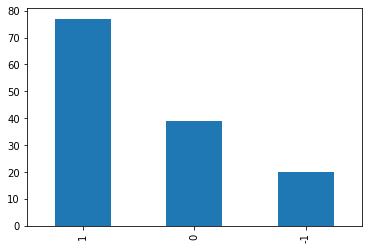

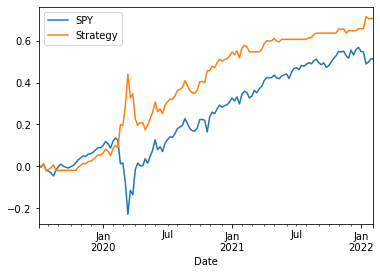

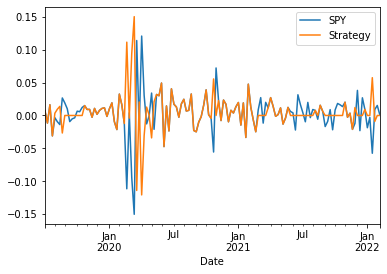

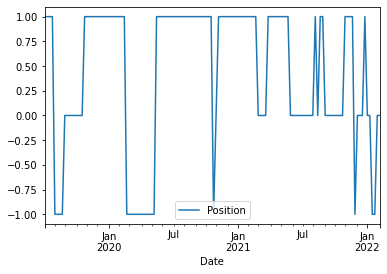

In [9]:
test = strategy(dftest)
results(test, 52)

## Now we use Daily Data

In [10]:
df2spy = pd.read_csv('SPY (1).csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
df2spy = df2spy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
df2spy = df2spy.rename(columns = {'Adj Close' : 'SPY Adj Close'})

df2vix = pd.read_csv('^VIX (1).csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
df2vix = df2vix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
df2vix = df2vix.rename(columns = {'Adj Close' : 'VIX Adj Close'})

df2 = df2spy.join(df2vix, on='Date')
df2train = df2[:(int(0.7*len(df2)))]
df2test = df2[(int(0.7*len(df2))):]

The median of rolling mean of SPY returns was 0.0006384598095860877
The median of rolling mean of our strategy P&L was 0.0013401034117789833
The median of rolling volatilty of SPY returns was 0.008603209073620454
The median of rolling volatilty of our strategy was 0.006427394990719333

The mean of rolling mean of SPY returns was 0.00036198275677511876
The mean of rolling mean of our strategy P&L was 0.0016823175062237081
The mean of rolling volatilty of SPY returns was 0.010731325414639756
The mean of rolling volatilty of our strategy was 0.00855902877300515

dataset Strategy sharpe ratio (annualized): 2.3504597399142857
datatset SPY sharpe ratio (annualized): 0.4289532108610013

Our positions' frequency are as follows: 
    Position
 1      1262
 0       838
-1       445

Mean returns of the long position (when it trades) are:  0.0018105517636445936
Mean returns of the short position (when it trades) are:  0.004497266740464992
Mean returns of SPY everyday is:  0.00035127593128371644



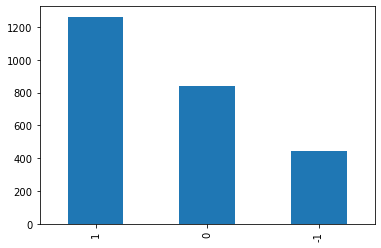

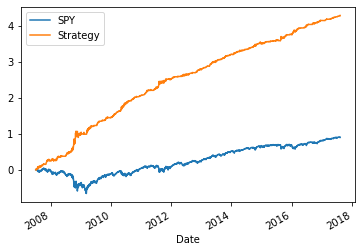

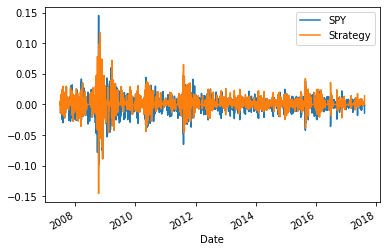

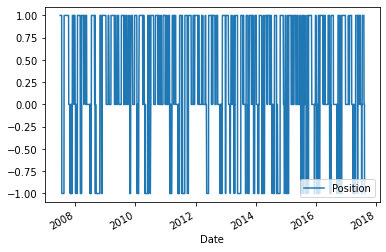

In [11]:
train2 = strategy(df2train)
results(train2, 252)

The median of rolling mean of SPY returns was 0.0009447778352668421
The median of rolling mean of our strategy P&L was 0.001532291195980584
The median of rolling volatilty of SPY returns was 0.008344691625358993
The median of rolling volatilty of our strategy was 0.007037093057287651

The mean of rolling mean of SPY returns was 0.0006442117710196472
The mean of rolling mean of our strategy P&L was 0.001843178170504824
The mean of rolling volatilty of SPY returns was 0.010554802188337778
The mean of rolling volatilty of our strategy was 0.009065272347784032

dataset Strategy sharpe ratio (annualized): 2.4004840904906453
datatset SPY sharpe ratio (annualized): 0.7811697448024582

Our positions' frequency are as follows: 
    Position
 1       561
 0       273
-1       200

Mean returns of the long position (when it trades) are:  0.0019214176500466935
Mean returns of the short position (when it trades) are:  0.004083945055278295
Mean returns of SPY everyday is:  0.0006443130229905878

Cum

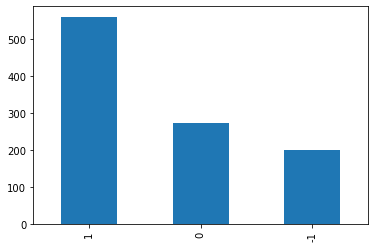

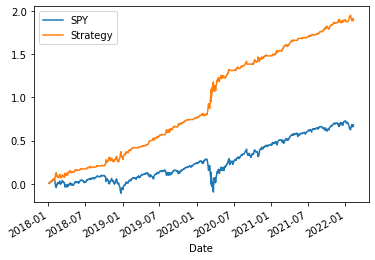

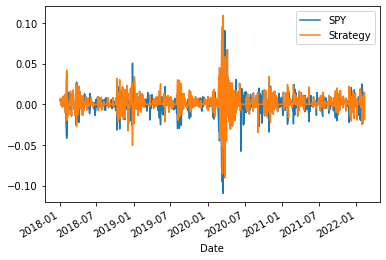

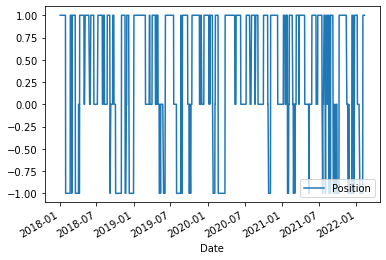

In [12]:
test2 = strategy(df2test)
results(test2, 252)

## Optimization

In [13]:
### List of parameters
###(df_og, ema_span=(12,26), sig_span=9, quant1=0.25, quant2=0.75, vix_span=100)
ema_span_list = [(6,12),(12,26),(15,30),(20,40),(24,48)]
sig_span_list = [6,9,12,15,18,21]
quant1_list = [0.1,0.15,0.2,0.25,0.3,0.4]
quant2_list = [0.9,0.85,0.8,0.75,0.7,0.6]
vix_span_list = [50,75,100,125,150]
sharpe_list1 = []
sharpe_list2 = []
param_list1 = []
param_list2 = []
for ema in ema_span_list:
    for sig in sig_span_list:
        for q1 in quant1_list:
            for q2 in quant2_list:
                for vix in vix_span_list:
                    answer = strategy(dftrain, ema, sig, q1, q2, vix)
                    sharpe_list1.append(answer['P&L'].mean()*np.sqrt(52)/train['P&L'].std())
                    param_list1.append({'ema span': ema,
                                       'sig span': sig,
                                       'quant1': q1,
                                       'quant2': q2,
                                       'vix span': vix})
                    answer2 = strategy(df2train, ema, sig, q1, q2, vix)
                    sharpe_list2.append(answer2['P&L'].mean()*np.sqrt(252)/train['P&L'].std())
                    param_list2.append({'ema span': ema,
                                       'sig span': sig,
                                       'quant1': q1,
                                       'quant2': q2,
                                       'vix span': vix})

In [14]:
len(ema_span_list)*len(sig_span_list)*len(quant1_list)*len(quant2_list)*len(vix_span_list)

5400

(array([  5.,  54., 159., 210., 376., 365., 473., 382., 304.,  64.]),
 array([-1.96541837, -1.496593  , -1.02776764, -0.55894227, -0.09011691,
         0.37870846,  0.84753382,  1.31635919,  1.78518455,  2.25400992,
         2.72283528]),
 <BarContainer object of 10 artists>)

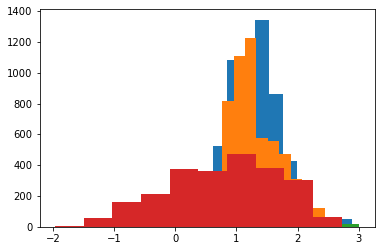

In [15]:
plt.hist(sharpe_list1)
plt.hist(sharpe_list2)
plt.hist(train['SPY returns'].rolling(52).mean()*np.sqrt(52)/train['SPY returns'].rolling(52).std())
plt.hist(train2['SPY returns'].rolling(252).mean()*np.sqrt(252)/train2['SPY returns'].rolling(252).std())

(array([ 816., 1110., 1224.,  576.,  558.,  474.,  312.,  156.,  120.,
          54.]),
 array([0.7700834 , 0.95570342, 1.14132344, 1.32694346, 1.51256349,
        1.69818351, 1.88380353, 2.06942356, 2.25504358, 2.4406636 ,
        2.62628363]),
 <BarContainer object of 10 artists>)

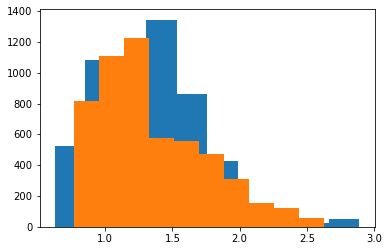

In [16]:
plt.hist(sharpe_list1)
plt.hist(sharpe_list2)

(array([ 8., 26., 26., 48., 81., 82., 97., 65., 47., 16.]),
 array([-1.85906466, -1.37244519, -0.88582572, -0.39920625,  0.08741323,
         0.5740327 ,  1.06065217,  1.54727164,  2.03389112,  2.52051059,
         3.00713006]),
 <BarContainer object of 10 artists>)

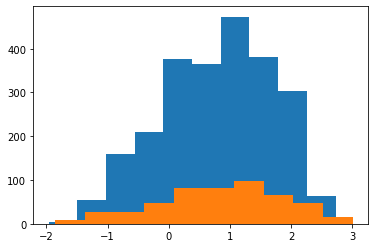

In [17]:
plt.hist(train2['SPY returns'].rolling(252).mean()*np.sqrt(252)/train2['SPY returns'].rolling(252).std())
plt.hist(train['SPY returns'].rolling(52).mean()*np.sqrt(52)/train['SPY returns'].rolling(52).std())

In [18]:
print(sum(sharpe_list1)/len(sharpe_list1))
print(sum(sharpe_list2)/len(sharpe_list2))

1.3301725555653308
1.351259777342397


In [19]:
print(min(sharpe_list1))
print(min(sharpe_list2))

0.6249760520838986
0.7700833958494946


In [21]:
print(param_list1[sharpe_list1.index(max(sharpe_list1))])
print(max(sharpe_list1))
print(param_list2[sharpe_list2.index(max(sharpe_list2))])
print(max(sharpe_list2))

{'ema span': (6, 12), 'sig span': 6, 'quant1': 0.1, 'quant2': 0.6, 'vix span': 50}
2.8903393510082114
{'ema span': (6, 12), 'sig span': 6, 'quant1': 0.1, 'quant2': 0.6, 'vix span': 50}
2.6262836261569036


In [22]:
print(train['SPY returns'].mean()*np.sqrt(52)/train['SPY returns'].std())
print(train2['SPY returns'].mean()*np.sqrt(252)/train2['SPY returns'].std())

0.47160409231493333
0.4513430864488229
